# Intro

In [126]:
import os
import os.path as op

import numpy as np
import scipy as sp
import pandas as pd
import sqlalchemy as sa

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, precision=4)

from common import dat

In [127]:
import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

height has been deprecated.



In [128]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [129]:
ch1_train_combination_and_monotherapy = pd.read_csv(
    'challenge_data/drug_synergy_data/ch1_train_combination_and_monotherapy.csv/'
    'ch1_train_combination_and_monoTherapy.csv', sep=','
)
display(ch1_train_combination_and_monotherapy.head())

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
0,BT-20,ADAM17,AKT,1,75,1.000000,0.809002,59.122436,9.639714,0.757977,91.593425,29.540390,1,ADAM17.AKT
1,CAL-120,ADAM17,AKT,1,75,0.183214,2.503678,60.411999,1.000000,0.000000,100.000000,4.401410,-1,ADAM17.AKT
2,CAL-51,ADAM17,AKT,1,75,1.000000,0.726984,11.150843,75.000000,0.375043,76.656479,0.315422,1,ADAM17.AKT
3,DU-4475,ADAM17,AKT,1,75,0.321533,10.000000,58.599487,75.000000,1.995866,6.171007,-41.734090,-1,ADAM17.AKT
4,HCC1143,ADAM17,AKT,1,75,0.398673,10.000000,89.098894,1.000000,0.000000,100.000000,35.532770,-1,ADAM17.AKT


In [130]:
# Print some statistics
ch_1_compounds = (
    set(ch1_train_combination_and_monotherapy['COMPOUND_A']) |
    set(ch1_train_combination_and_monotherapy['COMPOUND_B'])
)
dat.print2('Number of rows:', len(ch1_train_combination_and_monotherapy))
dat.print2('Number of cell lines:', len(set(ch1_train_combination_and_monotherapy['CELL_LINE'])))
dat.print2('Number of compoounds:', len(ch_1_compounds))

Number of rows:                                             2199
Number of cell lines:                                       85
Number of compoounds:                                       69


In [131]:
combinations_df_1 = (
    ch1_train_combination_and_monotherapy[
        (ch1_train_combination_and_monotherapy['QA'] > 0)
    ]
)

In [132]:
def get_stats(x):
    mean = np.mean(x)
    std = np.std(x)
    return np.array([mean, std])

In [133]:
combinations_df_2 = (
    combinations_df_1
    .groupby('COMBINATION_ID')['SYNERGY_SCORE']
    .agg([np.mean, np.std, len])
    .reset_index()
)

In [134]:
combinations_df_2.head()

,COMBINATION_ID,mean,std,len
0,ADAM17.AKT,9.837743,18.576485,10
1,ADAM17.BCL2_BCL2L1,-3.375640,5.741486,11
2,ADAM17.FGFR,-4.661734,18.047302,10
3,ADAM17.MAP2K_1,-1.385041,16.552645,11
4,ADAM17.MTOR_1,9.601303,18.506934,10


In [135]:
combinations_df_2['ste'] = combinations_df_2['std'] / np.sqrt(combinations_df_2['len'])

In [136]:
combinations_df_2['log_ste'] = np.log(combinations_df_2['ste'])

In [137]:
combinations_df_2['norm_log_ste'] = (
    (combinations_df_2['log_ste'] - combinations_df_2['log_ste'].min()) / 
    (combinations_df_2['log_ste'].max() - combinations_df_2['log_ste'].min())
)
combinations_df_2['norm_log_ste'] = 1 - combinations_df_2['norm_log_ste']

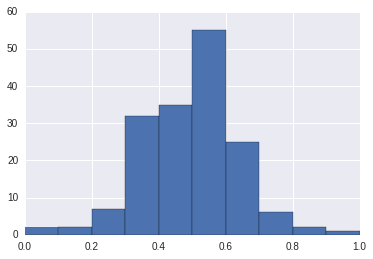

In [138]:
combinations_df_2['norm_log_ste'].hist()

# Leaderboard

In [139]:
ch1_leaderboard_monotherapy = pd.read_csv(
    'challenge_data/drug_synergy_data/ch1_leaderboard_monotherapy.csv/'
    'ch1_leaderBoard_monoTherapy.csv', sep=','
)

In [140]:
ch1_leaderboard_monotherapy.head()

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
0,BT-549,ADAM17,AKT,1,75,0.184408,1.737511,59.575233,1.0000,0.000000,100.000000,NaN,1,ADAM17.AKT
1,CAL-148,ADAM17,AKT,1,75,0.153391,1.754123,1.100779,1.0000,0.000000,100.000000,NaN,1,ADAM17.AKT
2,HCC38,ADAM17,AKT,1,75,1.000000,10.000000,64.400080,1.0000,0.000000,100.000000,NaN,1,ADAM17.AKT
3,BT-20,ADAM17,BCL2_BCL2L1,1,75,1.000000,1.161732,39.164587,75.0000,0.965792,70.915033,NaN,1,ADAM17.BCL2_BCL2L1
4,HCC1143,ADAM17,BCL2_BCL2L1,1,75,0.115309,10.000000,57.198795,0.0075,0.100000,80.128089,NaN,1,ADAM17.BCL2_BCL2L1


In [141]:
os.makedirs('output/subchallange_1a/', exist_ok=True)

## Submission 1

### prediction

In [142]:
prediction = (
    ch1_leaderboard_monotherapy
    [['CELL_LINE', 'COMBINATION_ID']]
    .merge(combinations_df_2[['COMBINATION_ID', 'mean']], on=['COMBINATION_ID'])
    .rename(columns={'mean':'PREDICTION'})
)

In [143]:
prediction.head()

,CELL_LINE,COMBINATION_ID,PREDICTION
0,BT-549,ADAM17.AKT,9.837743
1,CAL-148,ADAM17.AKT,9.837743
2,HCC38,ADAM17.AKT,9.837743
3,VCaP,ADAM17.AKT,9.837743
4,BT-20,ADAM17.BCL2_BCL2L1,-3.375640


In [144]:
prediction.to_csv(
    'output/subchallange_1a/prediction.csv', 
    index=False, quoting=2)

### combination_priority

In [145]:
combination_priority_1 = (
    combinations_df_2
    [['COMBINATION_ID', 'norm_log_ste']]
    .rename(columns={'norm_log_ste':'CONFIDENCE'})
)

In [146]:
combination_priority_1.head()

,COMBINATION_ID,CONFIDENCE
0,ADAM17.AKT,0.509331
1,ADAM17.BCL2_BCL2L1,0.844044
2,ADAM17.FGFR,0.517248
3,ADAM17.MAP2K_1,0.553985
4,ADAM17.MTOR_1,0.510359


In [147]:
combination_priority_1.to_csv(
    'output/subchallange_1a/combination_priority.csv', 
    index=False, quoting=2)

# The most basic thing